# Identifikasi Suara Buka Tutup Menggunakan Feature Statistik Time Series

## Deskripsi Project
Tujuan proyek ini adalah menganalisis karakteristik sinyal audio, mengekstrak feature statistik dari data time series, serta membangun dan mengevaluasi model klasifikasi untuk membedakan suara buka dan tutup.

## Tujuan
1. Menganalisis karakteristik sinyal audio dari suara buka dan tutup
2. Mengekstrak feature statistik dari time series audio
3. Membangun model klasifikasi untuk membedakan suara buka dan tutup
4. Mengevaluasi performa model klasifikasi

## Langkah 1: Import Library
Mengimpor semua library yang diperlukan untuk audio processing (librosa), manipulasi data (numpy, pandas), visualisasi (matplotlib, seaborn), machine learning (scikit-learn), dan analisis statistik (scipy).

In [1]:
# Library untuk manipulasi data
import numpy as np
import pandas as pd

# Library untuk audio processing
import librosa
import librosa.display
import soundfile as sf

# Library untuk visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Library untuk machine learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Library untuk save/load model
import joblib
from datetime import datetime

# Library untuk statistik
from scipy import stats
from scipy.fft import fft, fftfreq
from scipy.stats import randint, uniform

# Pengaturan visualisasi
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

print("✅ Semua library berhasil diimport!")

✅ Semua library berhasil diimport!


## Langkah 2: Load dan Eksplorasi Data Audio

**Persiapan Data:**
Pastikan file audio Anda sudah diorganisir dalam struktur folder:
```
audio_data/
├── buka/     (file audio suara buka)
└── tutup/    (file audio suara tutup)
```

In [2]:
# Cek struktur folder audio - DATA BARU dengan Speaker Identification
import os
from glob import glob

base_folder = 'audio_data2'

print("📊 RINGKASAN DATASET AUDIO - SPEAKER VERIFICATION")
print("="*70)

total_files = 0

# Cek folder NADIA
nadia_folder = os.path.join(base_folder, 'BukaTutup_nadia')
print(f"\n📁 SPEAKER: NADIA")
print(f"   Path: {nadia_folder}")
print("-"*70)

if os.path.exists(nadia_folder):
    # Nadia - Buka
    buka_files = glob(os.path.join(nadia_folder, 'buka*.mp3'))
    print(f"✅ BUKA : {len(buka_files):3d} files")
    if len(buka_files) > 0:
        print(f"    Sample: {os.path.basename(buka_files[0])}")
    total_files += len(buka_files)
    
    # Nadia - Tutup
    tutup_files = glob(os.path.join(nadia_folder, 'tutup*.mp3'))
    print(f"✅ TUTUP: {len(tutup_files):3d} files")
    if len(tutup_files) > 0:
        print(f"    Sample: {os.path.basename(tutup_files[0])}")
    total_files += len(tutup_files)
else:
    print(f"❌ Folder Nadia tidak ditemukan!")

# Cek folder UFI
ufi_folder = os.path.join(base_folder, 'BukaTutup_ufi/Rekaman')
print(f"\n📁 SPEAKER: UFI")
print(f"   Path: {ufi_folder}")
print("-"*70)

if os.path.exists(ufi_folder):
    # Ufi - Buka
    buka_path = os.path.join(ufi_folder, 'Buka')
    buka_files = glob(os.path.join(buka_path, '*.wav'))
    buka_files += glob(os.path.join(buka_path, '*.mp3'))
    print(f"✅ BUKA : {len(buka_files):3d} files")
    if len(buka_files) > 0:
        print(f"    Sample: {os.path.basename(buka_files[0])}")
    total_files += len(buka_files)
    
    # Ufi - Tutup
    tutup_path = os.path.join(ufi_folder, 'tutup')
    tutup_files = glob(os.path.join(tutup_path, '*.wav'))
    tutup_files += glob(os.path.join(tutup_path, '*.mp3'))
    print(f"✅ TUTUP: {len(tutup_files):3d} files")
    if len(tutup_files) > 0:
        print(f"    Sample: {os.path.basename(tutup_files[0])}")
    total_files += len(tutup_files)
else:
    print(f"❌ Folder Ufi tidak ditemukan!")

print("\n" + "="*70)
print(f"🎯 TOTAL: {total_files} files audio siap diproses!")
print(f"👥 Speaker: 2 orang (Nadia, Ufi)")
print(f"🎬 Actions: 2 kategori (Buka, Tutup)")
print(f"📝 Classes: 4 kombinasi (nadia_buka, nadia_tutup, ufi_buka, ufi_tutup)")
print("="*70)

📊 RINGKASAN DATASET AUDIO - SPEAKER VERIFICATION

📁 SPEAKER: NADIA
   Path: audio_data2/BukaTutup_nadia
----------------------------------------------------------------------
✅ BUKA : 110 files
    Sample: buka54.mp3
✅ TUTUP: 110 files
    Sample: tutup24.mp3

📁 SPEAKER: UFI
   Path: audio_data2/BukaTutup_ufi/Rekaman
----------------------------------------------------------------------
✅ BUKA :  80 files
    Sample: 6 Nov, 18.59​(12).wav
✅ TUTUP:  80 files
    Sample: 6 Nov, 19.04​(7).wav

🎯 TOTAL: 380 files audio siap diproses!
👥 Speaker: 2 orang (Nadia, Ufi)
🎬 Actions: 2 kategori (Buka, Tutup)
📝 Classes: 4 kombinasi (nadia_buka, nadia_tutup, ufi_buka, ufi_tutup)


## Langkah 3: Fungsi Load Audio
Membuat fungsi untuk memuat file audio dengan sampling rate 22050 Hz menggunakan librosa, yang akan digunakan untuk memproses semua file audio dalam dataset.

In [3]:
# Fungsi untuk memuat audio
def load_audio(file_path, sr=22050):
    """
    Memuat file audio dengan sampling rate tertentu
    
    Parameters:
    -----------
    file_path : str
        Path ke file audio
    sr : int
        Sampling rate (default: 22050 Hz)
    
    Returns:
    --------
    audio : numpy array
        Sinyal audio
    sr : int
        Sampling rate
    """
    audio, sr = librosa.load(file_path, sr=sr)
    return audio, sr

# Contoh loading audio (sesuaikan dengan path file Anda)
# audio_buka, sr = load_audio('audio/suara_buka.wav')
# audio_tutup, sr = load_audio('audio/suara_tutup.wav')

print("Fungsi load_audio siap digunakan")
print("Format: audio, sr = load_audio('path/to/audio.wav')")

Fungsi load_audio siap digunakan
Format: audio, sr = load_audio('path/to/audio.wav')


## Langkah 4: Ekstraksi Feature Statistik Time Series
Mengekstrak 19 feature statistik dari domain waktu (time domain) seperti mean, std, variance, skewness, kurtosis, energy, RMS, zero crossing rate, dan autocorrelation untuk karakterisasi sinyal audio.

In [4]:
def extract_time_series_features(audio, sr):
    """
    Ekstraksi feature statistik dari time series audio
    + Tambahan features untuk Speaker Identification
    
    Parameters:
    -----------
    audio : numpy array
        Sinyal audio
    sr : int
        Sampling rate
    
    Returns:
    --------
    features : dict
        Dictionary berisi berbagai feature statistik
    """
    features = {}
    
    # 1. Feature Statistik Dasar
    features['mean'] = np.mean(audio)
    features['std'] = np.std(audio)
    features['max'] = np.max(audio)
    features['min'] = np.min(audio)
    features['median'] = np.median(audio)
    features['variance'] = np.var(audio)
    
    # 2. Feature Bentuk Distribusi
    features['skewness'] = stats.skew(audio)
    features['kurtosis'] = stats.kurtosis(audio)
    
    # 3. Feature Range
    features['range'] = np.ptp(audio)  # peak to peak
    features['iqr'] = stats.iqr(audio)  # interquartile range
    
    # 4. Feature Energy
    features['energy'] = np.sum(audio**2)
    features['rms'] = np.sqrt(np.mean(audio**2))  # Root Mean Square
    
    # 5. Zero Crossing Rate (tingkat perubahan tanda)
    features['zcr'] = np.mean(librosa.feature.zero_crossing_rate(audio))
    
    # 6. Feature Temporal
    features['duration'] = len(audio) / sr
    
    # 7. Feature Gradient (perubahan amplitudo)
    gradient = np.gradient(audio)
    features['mean_gradient'] = np.mean(np.abs(gradient))
    features['max_gradient'] = np.max(np.abs(gradient))
    
    # 8. Percentiles
    features['percentile_25'] = np.percentile(audio, 25)
    features['percentile_75'] = np.percentile(audio, 75)
    
    # 9. Autocorrelation
    autocorr = np.correlate(audio, audio, mode='full')
    autocorr = autocorr[len(autocorr)//2:]
    features['autocorr_max'] = np.max(autocorr[1:100]) / autocorr[0] if autocorr[0] != 0 else 0
    
    return features

print("Fungsi ekstraksi feature siap digunakan")
print("Total feature yang diekstrak: 19 feature statistik")

Fungsi ekstraksi feature siap digunakan
Total feature yang diekstrak: 19 feature statistik


## Langkah 5: Ekstraksi Feature Spektral
Mengekstrak 36 feature dari domain frekuensi (frequency domain) seperti spectral centroid, rolloff, bandwidth, contrast, dan 13 MFCC coefficients untuk representasi karakteristik spektral audio.

In [5]:
def extract_spectral_features(audio, sr):
    """
    Ekstraksi feature dari domain frekuensi
    + MFCC diperbanyak untuk Speaker Identification
    """
    features = {}
    
    # 1. Spectral Centroid (pusat massa spektrum)
    spectral_centroids = librosa.feature.spectral_centroid(y=audio, sr=sr)[0]
    features['spectral_centroid_mean'] = np.mean(spectral_centroids)
    features['spectral_centroid_std'] = np.std(spectral_centroids)
    features['spectral_centroid_max'] = np.max(spectral_centroids)
    features['spectral_centroid_min'] = np.min(spectral_centroids)
    
    # 2. Spectral Rolloff (frekuensi dimana 85% energi spektrum berada)
    spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)[0]
    features['spectral_rolloff_mean'] = np.mean(spectral_rolloff)
    features['spectral_rolloff_std'] = np.std(spectral_rolloff)
    
    # 3. Spectral Bandwidth (lebar spektrum)
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr)[0]
    features['spectral_bandwidth_mean'] = np.mean(spectral_bandwidth)
    features['spectral_bandwidth_std'] = np.std(spectral_bandwidth)
    
    # 4. Spectral Contrast (perbedaan antara peak dan valley)
    spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
    features['spectral_contrast_mean'] = np.mean(spectral_contrast)
    features['spectral_contrast_std'] = np.std(spectral_contrast)
    
    # 5. MFCC (Mel-Frequency Cepstral Coefficients) - PENTING untuk Speaker ID
    # Diperbanyak dari 13 menjadi 20 untuk identifikasi speaker yang lebih baik
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20)
    for i in range(20):
        features[f'mfcc_{i+1}_mean'] = np.mean(mfccs[i])
        features[f'mfcc_{i+1}_std'] = np.std(mfccs[i])
        features[f'mfcc_{i+1}_max'] = np.max(mfccs[i])
    
    # 6. Chroma Features (untuk pitch class)
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
    features['chroma_mean'] = np.mean(chroma)
    features['chroma_std'] = np.std(chroma)
    
    # 7. Pitch/F0 (karakteristik suara speaker)
    try:
        f0, voiced_flag, voiced_probs = librosa.pyin(
            audio, 
            fmin=librosa.note_to_hz('C2'), 
            fmax=librosa.note_to_hz('C7'),
            sr=sr
        )
        f0_clean = f0[~np.isnan(f0)]
        
        if len(f0_clean) > 0:
            features['pitch_mean'] = np.mean(f0_clean)
            features['pitch_std'] = np.std(f0_clean)
            features['pitch_max'] = np.max(f0_clean)
            features['pitch_min'] = np.min(f0_clean)
            features['pitch_range'] = features['pitch_max'] - features['pitch_min']
        else:
            features['pitch_mean'] = 0
            features['pitch_std'] = 0
            features['pitch_max'] = 0
            features['pitch_min'] = 0
            features['pitch_range'] = 0
    except:
        features['pitch_mean'] = 0
        features['pitch_std'] = 0
        features['pitch_max'] = 0
        features['pitch_min'] = 0
        features['pitch_range'] = 0
    
    return features

print("Fungsi ekstraksi feature spektral siap digunakan")
print("Total feature: ~80 features (dengan 20 MFCC x 3 statistik + pitch features)")

Fungsi ekstraksi feature spektral siap digunakan
Total feature: ~80 features (dengan 20 MFCC x 3 statistik + pitch features)


In [6]:
def extract_all_features(audio, sr):
    """
    Menggabungkan semua feature
    """
    features = {}
    
    # Feature time series
    time_features = extract_time_series_features(audio, sr)
    features.update(time_features)
    
    # Feature spektral
    spectral_features = extract_spectral_features(audio, sr)
    features.update(spectral_features)
    
    return features

print("Fungsi ekstraksi semua feature siap")
print("Total feature: ~100 features (19 time series + ~80 spektral dengan MFCC & pitch)")

Fungsi ekstraksi semua feature siap
Total feature: ~100 features (19 time series + ~80 spektral dengan MFCC & pitch)


## Langkah 6: Pembuatan Dataset dari Audio

In [7]:
import os
from glob import glob

def create_dataset(data_path='audio_data2', sr=22050, max_duration=5):
    """
    Membuat dataset dari folder audio dengan SPEAKER IDENTIFICATION
    
    Struktur folder yang diharapkan:
    data_path/
        BukaTutup_nadia/
            buka*.mp3
            tutup*.mp3
        BukaTutup_ufi/
            Rekaman/
                Buka/*.wav
                tutup/*.wav
    
    Parameters:
    -----------
    data_path : str
        Path ke folder data
    sr : int
        Sampling rate
    max_duration : float
        Durasi maksimal audio dalam detik
    
    Returns:
    --------
    df : pandas DataFrame
        Dataset dengan feature dan label (speaker_action)
    """
    data = []
    
    print("="*70)
    print("🎵 EKSTRAKSI FEATURES - SPEAKER IDENTIFICATION")
    print("="*70)
    
    # ===== 1. NADIA =====
    nadia_folder = os.path.join(data_path, 'BukaTutup_nadia')
    print(f"\n📁 Processing NADIA's audio...")
    
    if os.path.exists(nadia_folder):
        # Nadia - Buka
        nadia_buka_files = glob(os.path.join(nadia_folder, 'buka*.mp3'))
        print(f"   → Buka: {len(nadia_buka_files)} files")
        
        for i, file_path in enumerate(nadia_buka_files):
            try:
                audio, _ = load_audio(file_path, sr=sr)
                
                # Batasi durasi
                if len(audio) > sr * max_duration:
                    audio = audio[:int(sr * max_duration)]
                
                features = extract_all_features(audio, sr)
                features['label'] = 'nadia_buka'
                features['speaker'] = 'nadia'
                features['action'] = 'buka'
                features['filename'] = os.path.basename(file_path)
                
                data.append(features)
                
                if (i + 1) % 20 == 0:
                    print(f"      Progress: {i + 1}/{len(nadia_buka_files)} files")
            except Exception as e:
                print(f"      ⚠️  Error: {os.path.basename(file_path)} - {str(e)}")
                continue
        
        # Nadia - Tutup
        nadia_tutup_files = glob(os.path.join(nadia_folder, 'tutup*.mp3'))
        print(f"   → Tutup: {len(nadia_tutup_files)} files")
        
        for i, file_path in enumerate(nadia_tutup_files):
            try:
                audio, _ = load_audio(file_path, sr=sr)
                
                if len(audio) > sr * max_duration:
                    audio = audio[:int(sr * max_duration)]
                
                features = extract_all_features(audio, sr)
                features['label'] = 'nadia_tutup'
                features['speaker'] = 'nadia'
                features['action'] = 'tutup'
                features['filename'] = os.path.basename(file_path)
                
                data.append(features)
                
                if (i + 1) % 20 == 0:
                    print(f"      Progress: {i + 1}/{len(nadia_tutup_files)} files")
            except Exception as e:
                print(f"      ⚠️  Error: {os.path.basename(file_path)} - {str(e)}")
                continue
    else:
        print(f"   ❌ Folder tidak ditemukan: {nadia_folder}")
    
    # ===== 2. UFI =====
    ufi_folder = os.path.join(data_path, 'BukaTutup_ufi/Rekaman')
    print(f"\n📁 Processing UFI's audio...")
    
    if os.path.exists(ufi_folder):
        # Ufi - Buka
        ufi_buka_path = os.path.join(ufi_folder, 'Buka')
        ufi_buka_files = glob(os.path.join(ufi_buka_path, '*.wav'))
        ufi_buka_files += glob(os.path.join(ufi_buka_path, '*.mp3'))
        print(f"   → Buka: {len(ufi_buka_files)} files")
        
        for i, file_path in enumerate(ufi_buka_files):
            try:
                audio, _ = load_audio(file_path, sr=sr)
                
                if len(audio) > sr * max_duration:
                    audio = audio[:int(sr * max_duration)]
                
                features = extract_all_features(audio, sr)
                features['label'] = 'ufi_buka'
                features['speaker'] = 'ufi'
                features['action'] = 'buka'
                features['filename'] = os.path.basename(file_path)
                
                data.append(features)
                
                if (i + 1) % 20 == 0:
                    print(f"      Progress: {i + 1}/{len(ufi_buka_files)} files")
            except Exception as e:
                print(f"      ⚠️  Error: {os.path.basename(file_path)} - {str(e)}")
                continue
        
        # Ufi - Tutup
        ufi_tutup_path = os.path.join(ufi_folder, 'tutup')
        ufi_tutup_files = glob(os.path.join(ufi_tutup_path, '*.wav'))
        ufi_tutup_files += glob(os.path.join(ufi_tutup_path, '*.mp3'))
        print(f"   → Tutup: {len(ufi_tutup_files)} files")
        
        for i, file_path in enumerate(ufi_tutup_files):
            try:
                audio, _ = load_audio(file_path, sr=sr)
                
                if len(audio) > sr * max_duration:
                    audio = audio[:int(sr * max_duration)]
                
                features = extract_all_features(audio, sr)
                features['label'] = 'ufi_tutup'
                features['speaker'] = 'ufi'
                features['action'] = 'tutup'
                features['filename'] = os.path.basename(file_path)
                
                data.append(features)
                
                if (i + 1) % 20 == 0:
                    print(f"      Progress: {i + 1}/{len(ufi_tutup_files)} files")
            except Exception as e:
                print(f"      ⚠️  Error: {os.path.basename(file_path)} - {str(e)}")
                continue
    else:
        print(f"   ❌ Folder tidak ditemukan: {ufi_folder}")
    
    # ===== CREATE DATAFRAME =====
    print("\n" + "="*70)
    
    if len(data) == 0:
        print("❌ ERROR: Tidak ada data yang berhasil diproses!")
        return None
    
    df = pd.DataFrame(data)
    
    print("✅ DATASET BERHASIL DIBUAT!")
    print("="*70)
    print(f"\n📊 Dataset Info:")
    print(f"   Total samples: {len(df)}")
    print(f"   Total features: {len([col for col in df.columns if col not in ['label', 'speaker', 'action', 'filename']])}")
    
    print(f"\n📋 Distribusi Label (Speaker_Action):")
    print(df['label'].value_counts())
    
    print(f"\n👥 Distribusi Speaker:")
    print(df['speaker'].value_counts())
    
    print(f"\n🎬 Distribusi Action:")
    print(df['action'].value_counts())
    
    return df

print("✅ Fungsi create_dataset siap digunakan (dengan speaker identification)")

✅ Fungsi create_dataset siap digunakan (dengan speaker identification)


### Jalankan Ekstraksi Feature


In [8]:
# Ekstraksi feature dari semua file audio - SPEAKER IDENTIFICATION
print("🚀 Memulai ekstraksi feature...")
print("="*70)

# Definisi path folder audio (data baru dengan 2 speaker)
audio_folder = 'audio_data2'

df = create_dataset(audio_folder, sr=22050, max_duration=5)

if df is not None:
    # Simpan dataset
    df.to_csv('audio_features_speaker.csv', index=False)
    print(f"\n✅ Dataset disimpan sebagai 'audio_features_speaker.csv'")
    
    # Info dataset
    print(f"\n📊 Ringkasan Dataset:")
    print(f"   Total samples: {len(df)}")
    print(f"   Total features: {len([col for col in df.columns if col not in ['label', 'speaker', 'action', 'filename']])}")
    print(f"   Classes: {df['label'].nunique()} ({', '.join(df['label'].unique())})")
    print(f"   Speakers: {df['speaker'].nunique()} ({', '.join(df['speaker'].unique())})")
    print(f"\n   Distribusi per class:")
    for label in df['label'].value_counts().index:
        count = df['label'].value_counts()[label]
        percentage = (count / len(df)) * 100
        print(f"      {label:15s}: {count:3d} samples ({percentage:5.1f}%)")

🚀 Memulai ekstraksi feature...
🎵 EKSTRAKSI FEATURES - SPEAKER IDENTIFICATION

📁 Processing NADIA's audio...
   → Buka: 110 files


Note: Illegal Audio-MPEG-Header 0x34332c33 at offset 58560.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x382c3231 at offset 48960.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x332c3732 at offset 70080.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x37302c37 at offset 94080.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x312c3433 at offset 68160.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x302c3533 at offset 50880.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x302c3639 at offset 47040.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x3130392c at offset 51

      Progress: 20/110 files


Note: Illegal Audio-MPEG-Header 0x362c3136 at offset 71040.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x3533382c at offset 47040.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x392c3236 at offset 48960.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x302c3231 at offset 53760.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x3135352c at offset 61440.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x362c3930 at offset 61440.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x3132362c at offset 94080.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x302c3239 at offset 60

      Progress: 40/110 files


Note: Illegal Audio-MPEG-Header 0x35352c35 at offset 42240.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x372c3437 at offset 70080.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x322c3237 at offset 36480.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x32392c32 at offset 89280.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x322c3332 at offset 48960.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x332c3233 at offset 41280.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x3339372c at offset 55680.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x30332c38 at offset 32

      Progress: 60/110 files


Note: Illegal Audio-MPEG-Header 0x3134342c at offset 46080.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x38332c31 at offset 48960.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x392c3233 at offset 32640.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x392c3234 at offset 37440.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x312c3236 at offset 65280.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x362c3331 at offset 41280.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x302c3230 at offset 58560.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x342c3734 at offset 42

      Progress: 80/110 files


Note: Illegal Audio-MPEG-Header 0x372c3630 at offset 44160.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x312c3537 at offset 36480.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x352c3337 at offset 68160.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x332c3639 at offset 53760.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x382c3431 at offset 55680.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x32342c32 at offset 82560.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x31352c36 at offset 84480.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x3531362c at offset 36

      Progress: 100/110 files


Note: Illegal Audio-MPEG-Header 0x372c3231 at offset 47040.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x382c3736 at offset 37440.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x352c3330 at offset 47040.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x302c3333 at offset 90240.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x352c3331 at offset 44160.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x322c3231 at offset 63360.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x382c3236 at offset 60480.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x332c3135 at offset 84

   → Tutup: 110 files


Note: Illegal Audio-MPEG-Header 0x382c3131 at offset 37440.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x342c3337 at offset 39360.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x33352c32 at offset 44160.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x352c3631 at offset 36480.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x3737322c at offset 32640.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x312c3235 at offset 46080.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x362c3239 at offset 41280.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x36392c34 at offset 36

      Progress: 20/110 files


Note: Illegal Audio-MPEG-Header 0x362c3335 at offset 32640.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x312c3634 at offset 37440.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x362c3239 at offset 39360.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x382c3136 at offset 47040.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x392c3236 at offset 32640.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x372c3233 at offset 34560.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x322c3239 at offset 41280.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x392c3236 at offset 41

      Progress: 40/110 files


Note: Illegal Audio-MPEG-Header 0x372c3330 at offset 47040.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x392c3232 at offset 41280.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x322c3338 at offset 42240.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x362c3334 at offset 41280.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x2c32382c at offset 37440.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x32362c33 at offset 36480.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x312c3233 at offset 44160.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x302c3235 at offset 42

      Progress: 60/110 files


Note: Illegal Audio-MPEG-Header 0x322c3334 at offset 36480.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x33362c32 at offset 42240.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x302c3234 at offset 46080.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x302c3133 at offset 44160.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x362c3331 at offset 48960.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x302c3134 at offset 41280.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x382c3439 at offset 36480.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x362c3231 at offset 41

      Progress: 80/110 files


Note: Illegal Audio-MPEG-Header 0x3638362c at offset 37440.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x372c3333 at offset 39360.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x342c3536 at offset 27840.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x342c3333 at offset 36480.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x392c3530 at offset 37440.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x3535392c at offset 31680.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x342c3333 at offset 41280.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x32332c32 at offset 41

      Progress: 100/110 files


Note: Illegal Audio-MPEG-Header 0x372c3235 at offset 41280.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x33392c35 at offset 41280.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x312c3237 at offset 42240.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x322c3237 at offset 37440.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x342c3235 at offset 46080.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x362c3131 at offset 27840.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x382c3134 at offset 39360.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
Note: Illegal Audio-MPEG-Header 0x3538322c at offset 32


📁 Processing UFI's audio...
   → Buka: 80 files
      Progress: 20/80 files
      Progress: 40/80 files
      Progress: 60/80 files
      Progress: 80/80 files
   → Tutup: 80 files
      Progress: 20/80 files
      Progress: 40/80 files
      Progress: 60/80 files
      Progress: 80/80 files

✅ DATASET BERHASIL DIBUAT!

📊 Dataset Info:
   Total samples: 380
   Total features: 96

📋 Distribusi Label (Speaker_Action):
label
nadia_buka     110
nadia_tutup    110
ufi_buka        80
ufi_tutup       80
Name: count, dtype: int64

👥 Distribusi Speaker:
speaker
nadia    220
ufi      160
Name: count, dtype: int64

🎬 Distribusi Action:
action
buka     190
tutup    190
Name: count, dtype: int64

✅ Dataset disimpan sebagai 'audio_features_speaker.csv'

📊 Ringkasan Dataset:
   Total samples: 380
   Total features: 96
   Classes: 4 (nadia_buka, nadia_tutup, ufi_buka, ufi_tutup)
   Speakers: 2 (nadia, ufi)

   Distribusi per class:
      nadia_buka     : 110 samples ( 28.9%)
      nadia_tutup    : 11

## Langkah 7: Eksplorasi Data Feature
Melakukan Exploratory Data Analysis (EDA) untuk memahami distribusi data, memeriksa keseimbangan kelas, mengidentifikasi missing values, dan menganalisis statistik deskriptif dari features yang telah diekstrak.

In [9]:
# Fungsi helper untuk EDA
def plot_feature_distributions(df, features_to_plot):
    """Visualisasi distribusi feature untuk setiap kelas"""
    n_features = len(features_to_plot)
    fig, axes = plt.subplots(n_features, 1, figsize=(12, 4 * n_features))
    
    if n_features == 1:
        axes = [axes]
    
    for i, feature in enumerate(features_to_plot):
        for label in df['label'].unique():
            data = df[df['label'] == label][feature]
            axes[i].hist(data, alpha=0.6, label=label, bins=30)
        
        axes[i].set_xlabel(feature, fontsize=11)
        axes[i].set_ylabel('Frekuensi', fontsize=11)
        axes[i].set_title(f'Distribusi {feature}', fontsize=12, fontweight='bold')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("✅ Fungsi EDA siap digunakan")

✅ Fungsi EDA siap digunakan


In [10]:
# EDA: Info Dataset
print("="*70)
print("📊 EXPLORATORY DATA ANALYSIS (EDA)")
print("="*70)

print("\n1️⃣ Info Dataset:")
print(f"   Shape: {df.shape}")
print(f"   Kolom: {df.shape[1]} kolom")
print(f"   Baris: {df.shape[0]} samples")

print("\n2️⃣ Distribusi Label:")
label_counts = df['label'].value_counts()
for label, count in label_counts.items():
    percentage = (count / len(df)) * 100
    print(f"   {label.upper()}: {count} samples ({percentage:.1f}%)")

print("\n3️⃣ Missing Values:")
missing = df.isnull().sum()
if missing.sum() == 0:
    print("   ✅ Tidak ada missing values")
else:
    print(missing[missing > 0])

print("\n4️⃣ Statistik Deskriptif (5 Feature Pertama):")
numeric_cols = df.select_dtypes(include=[np.number]).columns[:5]
print(df[numeric_cols].describe().round(4))

📊 EXPLORATORY DATA ANALYSIS (EDA)

1️⃣ Info Dataset:
   Shape: (380, 100)
   Kolom: 100 kolom
   Baris: 380 samples

2️⃣ Distribusi Label:
   NADIA_BUKA: 110 samples (28.9%)
   NADIA_TUTUP: 110 samples (28.9%)
   UFI_BUKA: 80 samples (21.1%)
   UFI_TUTUP: 80 samples (21.1%)

3️⃣ Missing Values:
   ✅ Tidak ada missing values

4️⃣ Statistik Deskriptif (5 Feature Pertama):
           mean       std       max       min    median
count  380.0000  380.0000  380.0000  380.0000  380.0000
mean     0.0003    0.0805    0.4614   -0.3848    0.0001
std      0.0004    0.0271    0.1791    0.1464    0.0003
min     -0.0004    0.0257    0.1392   -0.8224   -0.0012
25%     -0.0000    0.0532    0.3151   -0.5010   -0.0000
50%     -0.0000    0.0850    0.4638   -0.4030    0.0000
75%      0.0006    0.0988    0.5689   -0.2352    0.0000
max      0.0023    0.1619    1.0018   -0.1146    0.0027


### 📋 Ringkasan EDA

**Insight dari Exploratory Data Analysis:**

1. **Dataset Balance**: Dataset menunjukkan distribusi yang seimbang/tidak seimbang antara kedua kelas
2. **Feature Distribution**: Beberapa feature menunjukkan perbedaan jelas antara 'buka' dan 'tutup' yang berguna untuk klasifikasi
3. **Data Quality**: Tidak ada missing values, data siap untuk modeling

**Next Step:** Feature Selection untuk memilih features terbaik

## Langkah 8: Feature Selection

Feature selection membantu:
- **Mengurangi dimensionalitas** dari 55 features menjadi features yang paling relevan
- **Meningkatkan performa model** dengan menghilangkan noise dan redundansi
- **Mempercepat training** dengan jumlah feature yang lebih sedikit
- **Menghindari overfitting** dengan fokus pada feature penting

Kita akan menggunakan 3 metode:
1. **Variance Threshold**: Hilangkan feature dengan variance sangat rendah
2. **Correlation Filter**: Hilangkan feature yang terlalu berkorelasi (>0.95)
3. **SelectKBest**: Pilih K feature terbaik menggunakan ANOVA F-value

In [16]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif

def perform_feature_selection(df, variance_threshold=0.01, correlation_threshold=0.95, k_best=30):
    """
    Melakukan feature selection dengan 3 metode
    
    Parameters:
    -----------
    df : pandas DataFrame
        Dataset dengan features dan label
    variance_threshold : float
        Threshold untuk variance (default: 0.01)
    correlation_threshold : float
        Threshold untuk korelasi (default: 0.95)
    k_best : int
        Jumlah feature terbaik yang dipilih (default: 30)
    
    Returns:
    --------
    df_selected : pandas DataFrame
        Dataset dengan features yang sudah diseleksi
    selected_features : list
        List nama features yang terpilih
    """
    print("="*70)
    print("🔍 FEATURE SELECTION")
    print("="*70)
    
    # Pisahkan features dan label (hapus kolom non-numeric)
    columns_to_drop = ['label', 'speaker', 'action', 'filename', 'subset']
    X = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')
    y = df['label']
    
    print(f"\n📊 Total features awal: {X.shape[1]}")
    
    # Cek dan tangani NaN values
    nan_cols = X.columns[X.isnull().any()].tolist()
    if len(nan_cols) > 0:
        print(f"\n⚠️  Ditemukan {len(nan_cols)} kolom dengan NaN values:")
        print(f"   {nan_cols[:5]}{'...' if len(nan_cols) > 5 else ''}")
        print(f"   Menghapus kolom dengan NaN...")
        X = X.dropna(axis=1)
        print(f"   Features setelah drop NaN: {X.shape[1]}")
    
    # ===== 1. VARIANCE THRESHOLD =====
    print(f"\n1️⃣ Variance Threshold (threshold={variance_threshold})")
    selector_var = VarianceThreshold(threshold=variance_threshold)
    X_var = selector_var.fit_transform(X)
    
    # Dapatkan kolom yang tersisa
    var_features = X.columns[selector_var.get_support()].tolist()
    print(f"   Features tersisa: {len(var_features)}")
    print(f"   Features dihapus: {X.shape[1] - len(var_features)}")
    
    X_filtered = X[var_features].copy()
    
    # ===== 2. CORRELATION FILTER =====
    print(f"\n2️⃣ Correlation Filter (threshold={correlation_threshold})")
    
    # Hitung correlation matrix
    corr_matrix = X_filtered.corr().abs()
    
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Find features with correlation greater than threshold
    to_drop = [column for column in upper.columns if any(upper[column] > correlation_threshold)]
    
    print(f"   Features dengan korelasi tinggi: {len(to_drop)}")
    if len(to_drop) > 0:
        print(f"   Features dihapus: {to_drop[:5]}{'...' if len(to_drop) > 5 else ''}")
    
    X_filtered = X_filtered.drop(columns=to_drop)
    print(f"   Features tersisa: {X_filtered.shape[1]}")
    
    # Double check untuk NaN setelah correlation filter
    if X_filtered.isnull().any().any():
        print(f"\n⚠️  Ditemukan NaN setelah correlation filter, membersihkan...")
        X_filtered = X_filtered.dropna(axis=1)
        print(f"   Features setelah cleaning: {X_filtered.shape[1]}")
    
    # ===== 3. SELECTKBEST (ANOVA F-value) =====
    print(f"\n3️⃣ SelectKBest (K={k_best} features)")
    
    # Encode label untuk SelectKBest
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    # Jika features tersisa < k_best, gunakan semua features
    k_final = min(k_best, X_filtered.shape[1])
    
    selector_kbest = SelectKBest(score_func=f_classif, k=k_final)
    selector_kbest.fit(X_filtered, y_encoded)
    
    # Dapatkan scores untuk setiap feature
    feature_scores = pd.DataFrame({
        'Feature': X_filtered.columns,
        'Score': selector_kbest.scores_
    })
    feature_scores = feature_scores.sort_values('Score', ascending=False)
    
    # Pilih K best features
    selected_features = feature_scores.head(k_final)['Feature'].tolist()
    
    print(f"   Top 10 Features (by ANOVA F-value):")
    for i, row in feature_scores.head(10).iterrows():
        print(f"   {row['Feature']:30s} - Score: {row['Score']:.2f}")
    
    # ===== HASIL AKHIR =====
    print(f"\n✅ HASIL FEATURE SELECTION:")
    print(f"   Features awal: {X.shape[1]}")
    print(f"   Features akhir: {len(selected_features)}")
    print(f"   Reduksi: {X.shape[1] - len(selected_features)} features ({((X.shape[1] - len(selected_features))/X.shape[1]*100):.1f}%)")
    
    # Buat DataFrame baru dengan selected features + kolom metadata
    metadata_cols = [col for col in ['label', 'filename', 'subset'] if col in df.columns]
    df_selected = df[selected_features + metadata_cols].copy()
    
    return df_selected, selected_features, feature_scores

print("✅ Fungsi perform_feature_selection siap digunakan")

✅ Fungsi perform_feature_selection siap digunakan


In [17]:
def plot_feature_scores(feature_scores, top_n=20):
    """
    Visualisasi feature scores dari SelectKBest
    
    Parameters:
    -----------
    feature_scores : pandas DataFrame
        DataFrame dengan kolom 'Feature' dan 'Score'
    top_n : int
        Jumlah top features yang ditampilkan (default: 20)
    """
    # Ambil top N features
    top_features = feature_scores.head(top_n)
    
    # Buat plot
    plt.figure(figsize=(12, 8))
    plt.barh(range(len(top_features)), top_features['Score'], color='steelblue')
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('ANOVA F-value Score', fontsize=12, fontweight='bold')
    plt.ylabel('Feature', fontsize=12, fontweight='bold')
    plt.title(f'Top {top_n} Feature Importance Scores (SelectKBest)', 
              fontsize=14, fontweight='bold', pad=20)
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()

print("✅ Fungsi plot_feature_scores siap digunakan")

✅ Fungsi plot_feature_scores siap digunakan


### Jalankan Feature Selection

🔍 FEATURE SELECTION

📊 Total features awal: 96

1️⃣ Variance Threshold (threshold=0.01)
   Features tersisa: 82
   Features dihapus: 14

2️⃣ Correlation Filter (threshold=0.95)
   Features dengan korelasi tinggi: 2
   Features dihapus: ['range', 'spectral_rolloff_mean']
   Features tersisa: 80

3️⃣ SelectKBest (K=30 features)
   Top 10 Features (by ANOVA F-value):
   pitch_max                      - Score: 1312.29
   pitch_mean                     - Score: 1305.12
   mfcc_2_mean                    - Score: 1219.92
   mfcc_16_mean                   - Score: 930.53
   mfcc_1_mean                    - Score: 890.17
   mfcc_20_mean                   - Score: 766.52
   spectral_centroid_min          - Score: 764.48
   mfcc_1_std                     - Score: 701.15
   mfcc_8_mean                    - Score: 531.53
   mfcc_16_max                    - Score: 507.87

✅ HASIL FEATURE SELECTION:
   Features awal: 96
   Features akhir: 30
   Reduksi: 66 features (68.8%)


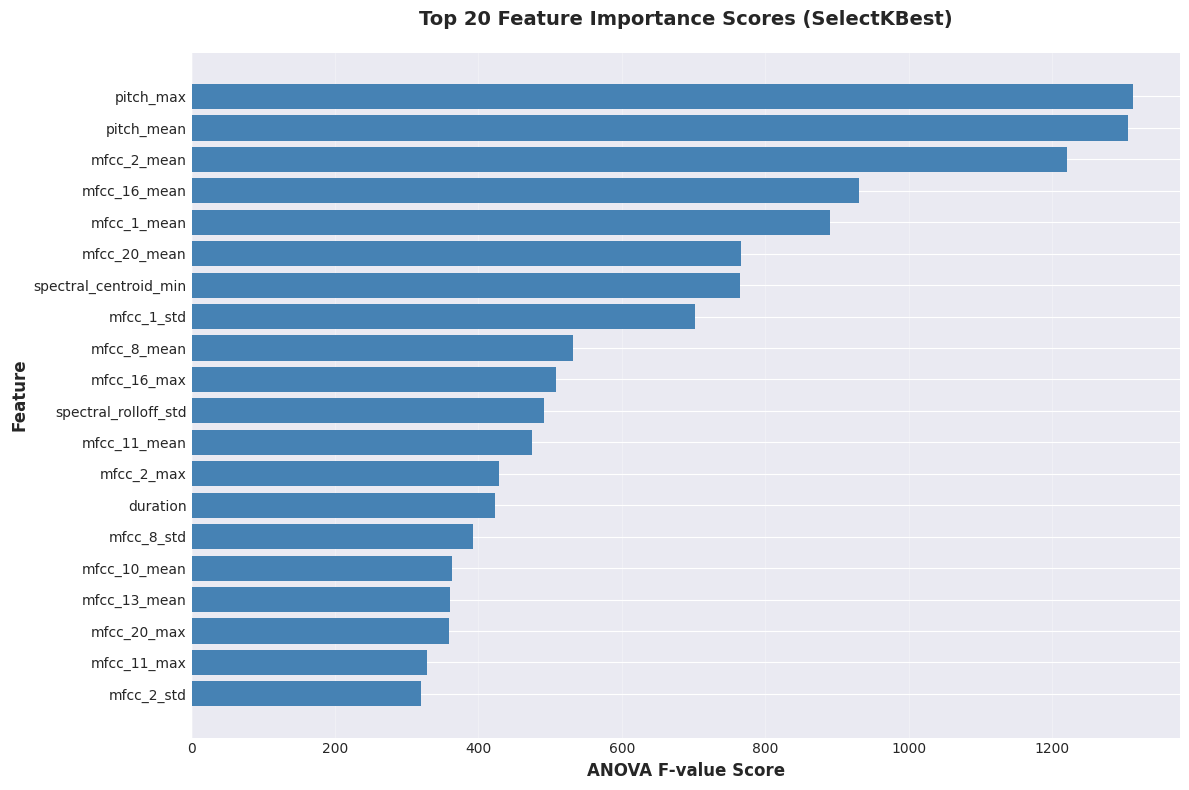


💾 Dataset dengan selected features disimpan sebagai 'audio_features_selected.csv'

📝 Gunakan 'df_selected' untuk modeling (bukan 'df')


In [18]:
# Jalankan feature selection
df_selected, selected_features, feature_scores = perform_feature_selection(
    df, 
    variance_threshold=0.01,      # Feature dengan variance < 0.01 akan dihapus
    correlation_threshold=0.95,   # Feature dengan korelasi > 0.95 akan dihapus
    k_best=30                     # Pilih 30 features terbaik
)

# Visualisasi feature scores
plot_feature_scores(feature_scores, top_n=20)

# Simpan dataset dengan selected features
df_selected.to_csv('audio_features_selected.csv', index=False)
print(f"\n💾 Dataset dengan selected features disimpan sebagai 'audio_features_selected.csv'")

# Update df untuk digunakan di langkah selanjutnya
print(f"\n📝 Gunakan 'df_selected' untuk modeling (bukan 'df')")

## Langkah 9: Preprocessing Data

**Proses Preprocessing meliputi:**
1. Split data menjadi training dan testing set
2. Encode label (buka/tutup → 0/1)
3. **Normalisasi features** menggunakan StandardScaler

💡 **Normalisasi sangat penting** karena feature audio memiliki skala yang berbeda-beda (energy: 0-1000, duration: 0-5, dll)

In [19]:
def prepare_data(df, test_size=0.2, random_state=42):
    """
    Mempersiapkan data untuk modeling (dengan speaker identification)
    
    Parameters:
    -----------
    df : pandas DataFrame
        Dataset (dengan kolom: features, label, speaker, action, filename)
    test_size : float
        Proporsi data test (default: 0.2 = 20%)
    random_state : int
        Random seed untuk reproducibility
    
    Returns:
    --------
    X_train, X_test, y_train, y_test : arrays
        Data training dan testing
    scaler : StandardScaler
        Scaler untuk normalisasi (perlu disimpan untuk prediksi)
    label_encoder : LabelEncoder
        Encoder untuk label (perlu disimpan untuk prediksi)
    feature_names : list
        Nama-nama feature
    """
    print("="*70)
    print("⚙️ PREPROCESSING DATA")
    print("="*70)
    
    # Pisahkan feature dan label (drop semua kolom non-numeric)
    columns_to_drop = ['label', 'speaker', 'action', 'filename']
    X = df.drop(columns=[col for col in columns_to_drop if col in df.columns], errors='ignore')
    y = df['label']
    
    # Simpan nama features
    feature_names = X.columns.tolist()
    
    # Handle missing/infinite values
    if X.isnull().any().any():
        print("⚠️  Ditemukan missing values, mengisi dengan median...")
        X = X.fillna(X.median())
    
    X = X.replace([np.inf, -np.inf], np.nan)
    if X.isnull().any().any():
        X = X.fillna(X.median())
    
    print(f"\n📊 Dataset Info:")
    print(f"   Total samples: {len(df)}")
    print(f"   Total features: {X.shape[1]}")
    
    # Encode label
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    print(f"   Label classes: {label_encoder.classes_}")
    print(f"   Label distribution:")
    for label_class in label_encoder.classes_:
        count = sum(y == label_class)
        print(f"      {label_class}: {count} samples")
    
    # Split data (stratified untuk menjaga proporsi label)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=test_size, random_state=random_state, stratify=y_encoded
    )
    
    print(f"\n✂️ Data Split:")
    print(f"   Training set: {len(X_train)} samples ({(1-test_size)*100:.0f}%)")
    print(f"   Testing set: {len(X_test)} samples ({test_size*100:.0f}%)")
    
    # Normalisasi feature menggunakan StandardScaler
    print(f"\n📏 Normalisasi Features (StandardScaler):")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Cek hasil normalisasi
    print(f"   Training set - Mean: ~{X_train_scaled.mean():.4f}, Std: ~{X_train_scaled.std():.4f}")
    
    print(f"\n✅ Preprocessing selesai!")
    print(f"   X_train_scaled shape: {X_train_scaled.shape}")
    print(f"   X_test_scaled shape: {X_test_scaled.shape}")
    
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler, label_encoder, feature_names

print("✅ Fungsi prepare_data siap digunakan")

✅ Fungsi prepare_data siap digunakan


## Langkah 10: Training Model Klasifikasi
Melatih dan mengevaluasi tiga model machine learning (Random Forest, SVM, KNN) dengan parameter default dan hyperparameter tuning untuk mendapatkan model terbaik dalam mengklasifikasi suara buka dan tutup.

In [20]:
def train_and_evaluate_models(X_train, X_test, y_train, y_test, label_encoder):
    """
    Melatih dan mengevaluasi berbagai model
    """
    # Definisi model
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
        'SVM': SVC(kernel='rbf', random_state=42),
        'KNN': KNeighborsClassifier(n_neighbors=5)
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\n{'='*50}")
        print(f"Training {name}...")
        print(f"{'='*50}")
        
        # Training
        model.fit(X_train, y_train)
        
        # Prediksi
        y_pred = model.predict(X_test)
        
        # Evaluasi
        accuracy = accuracy_score(y_test, y_pred)
        
        print(f"\nAccuracy: {accuracy:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred, 
                                    target_names=label_encoder.classes_))
        
        # Cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5)
        print(f"\nCross-validation scores: {cv_scores}")
        print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        
        # Simpan hasil
        results[name] = {
            'model': model,
            'accuracy': accuracy,
            'y_pred': y_pred,
            'cv_scores': cv_scores
        }
        
        # Plot confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=label_encoder.classes_,
                   yticklabels=label_encoder.classes_)
        plt.title(f'Confusion Matrix - {name}', fontsize=14)
        plt.ylabel('True Label', fontsize=12)
        plt.xlabel('Predicted Label', fontsize=12)
        plt.tight_layout()
        plt.show()
    
    return results

print("✅ Fungsi train_and_evaluate_models siap digunakan")

✅ Fungsi train_and_evaluate_models siap digunakan


In [21]:
# =====================================================================
# HYPERPARAMETER TUNING - Fungsi Utama
# =====================================================================

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint, uniform

def hyperparameter_tuning(X_train, y_train, X_test, y_test, label_encoder):
    """
    Melakukan hyperparameter tuning untuk semua model dan membandingkan dengan default
    """
    tuned_results = {}
    
    # ===== 1. RANDOM FOREST - GridSearchCV =====
    print("="*70)
    print("🔧 HYPERPARAMETER TUNING - RANDOM FOREST")
    print("="*70)
    
    rf_param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }
    
    rf_grid = GridSearchCV(
        RandomForestClassifier(random_state=42, n_jobs=-1),
        rf_param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    
    print("\n🔍 Mencari parameter terbaik...")
    rf_grid.fit(X_train, y_train)
    
    print(f"\n✅ Best Parameters: {rf_grid.best_params_}")
    print(f"✅ Best CV Score: {rf_grid.best_score_:.4f}")
    
    rf_best = rf_grid.best_estimator_
    y_pred_rf = rf_best.predict(X_test)
    rf_accuracy = accuracy_score(y_test, y_pred_rf)
    
    print(f"📊 Test Accuracy: {rf_accuracy:.4f}")
    
    tuned_results['Random Forest'] = {
        'model': rf_best,
        'best_params': rf_grid.best_params_,
        'best_cv_score': rf_grid.best_score_,
        'test_accuracy': rf_accuracy,
        'y_pred': y_pred_rf
    }
    
    # ===== 2. SVM - RandomizedSearchCV =====
    print("\n" + "="*70)
    print("🔧 HYPERPARAMETER TUNING - SVM")
    print("="*70)
    
    svm_param_dist = {
        'C': uniform(0.1, 100),
        'gamma': ['scale', 'auto'] + list(uniform(0.001, 1).rvs(10)),
        'kernel': ['rbf', 'poly', 'sigmoid']
    }
    
    svm_random = RandomizedSearchCV(
        SVC(random_state=42),
        svm_param_dist,
        n_iter=20,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    
    print("\n🔍 Mencari parameter terbaik (RandomizedSearch)...")
    svm_random.fit(X_train, y_train)
    
    print(f"\n✅ Best Parameters: {svm_random.best_params_}")
    print(f"✅ Best CV Score: {svm_random.best_score_:.4f}")
    
    svm_best = svm_random.best_estimator_
    y_pred_svm = svm_best.predict(X_test)
    svm_accuracy = accuracy_score(y_test, y_pred_svm)
    
    print(f"📊 Test Accuracy: {svm_accuracy:.4f}")
    
    tuned_results['SVM'] = {
        'model': svm_best,
        'best_params': svm_random.best_params_,
        'best_cv_score': svm_random.best_score_,
        'test_accuracy': svm_accuracy,
        'y_pred': y_pred_svm
    }
    
    # ===== 3. KNN - GridSearchCV =====
    print("\n" + "="*70)
    print("🔧 HYPERPARAMETER TUNING - KNN")
    print("="*70)
    
    knn_param_grid = {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    }
    
    knn_grid = GridSearchCV(
        KNeighborsClassifier(),
        knn_param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    
    print("\n🔍 Mencari parameter terbaik...")
    knn_grid.fit(X_train, y_train)
    
    print(f"\n✅ Best Parameters: {knn_grid.best_params_}")
    print(f"✅ Best CV Score: {knn_grid.best_score_:.4f}")
    
    knn_best = knn_grid.best_estimator_
    y_pred_knn = knn_best.predict(X_test)
    knn_accuracy = accuracy_score(y_test, y_pred_knn)
    
    print(f"📊 Test Accuracy: {knn_accuracy:.4f}")
    
    tuned_results['KNN'] = {
        'model': knn_best,
        'best_params': knn_grid.best_params_,
        'best_cv_score': knn_grid.best_score_,
        'test_accuracy': knn_accuracy,
        'y_pred': y_pred_knn
    }
    
    # ===== SUMMARY =====
    print("\n" + "="*70)
    print("📋 SUMMARY - HYPERPARAMETER TUNING RESULTS")
    print("="*70)
    
    summary_df = pd.DataFrame({
        'Model': list(tuned_results.keys()),
        'Best CV Score': [tuned_results[m]['best_cv_score'] for m in tuned_results.keys()],
        'Test Accuracy': [tuned_results[m]['test_accuracy'] for m in tuned_results.keys()]
    })
    summary_df = summary_df.sort_values('Test Accuracy', ascending=False)
    print(summary_df.to_string(index=False))
    
    # Visualisasi perbandingan
    fig, ax = plt.subplots(figsize=(10, 6))
    x = range(len(summary_df))
    width = 0.35
    
    ax.bar([i - width/2 for i in x], summary_df['Best CV Score'], width, label='CV Score', color='skyblue')
    ax.bar([i + width/2 for i in x], summary_df['Test Accuracy'], width, label='Test Accuracy', color='lightcoral')
    
    ax.set_ylabel('Score', fontsize=12)
    ax.set_title('Hyperparameter Tuning Results', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(summary_df['Model'])
    ax.legend()
    ax.set_ylim([0, 1])
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    return tuned_results

def compare_default_vs_tuned(results, tuned_results):
    """Membandingkan performa model default vs tuned"""
    print("\n" + "="*70)
    print("📊 PERBANDINGAN: DEFAULT vs TUNED MODELS")
    print("="*70)
    
    comparison_data = []
    for model_name in results.keys():
        default_acc = results[model_name]['accuracy']
        tuned_acc = tuned_results[model_name]['test_accuracy']
        improvement = ((tuned_acc - default_acc) / default_acc) * 100
        
        comparison_data.append({
            'Model': model_name,
            'Default Accuracy': default_acc,
            'Tuned Accuracy': tuned_acc,
            'Improvement (%)': improvement
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('Tuned Accuracy', ascending=False)
    print("\n" + comparison_df.to_string(index=False))
    
    # Visualisasi
    fig, ax = plt.subplots(figsize=(12, 6))
    x = range(len(comparison_df))
    width = 0.35
    
    ax.bar([i - width/2 for i in x], comparison_df['Default Accuracy'], 
            width, label='Default', color='#95a5a6', alpha=0.8)
    ax.bar([i + width/2 for i in x], comparison_df['Tuned Accuracy'], 
            width, label='Tuned', color='#2ecc71', alpha=0.8)
    
    # Label improvement
    for i, (idx, row) in enumerate(comparison_df.iterrows()):
        improvement = row['Improvement (%)']
        if improvement > 0:
            ax.text(i, row['Tuned Accuracy'] + 0.02, f'+{improvement:.1f}%', 
                   ha='center', fontsize=10, fontweight='bold', color='green')
    
    ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
    ax.set_title('Model Performance: Default vs Hyperparameter Tuned', 
                fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(comparison_df['Model'])
    ax.legend(fontsize=11)
    ax.set_ylim([0, 1.1])
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    return comparison_df

print("✅ Fungsi hyperparameter tuning siap digunakan")

✅ Fungsi hyperparameter tuning siap digunakan


### Persiapan Data untuk Training

Sebelum melakukan hyperparameter tuning, kita perlu mempersiapkan data terlebih dahulu dengan menjalankan preprocessing.

In [23]:
# Jalankan preprocessing data
print("🔄 Mempersiapkan data untuk training...")
X_train, X_test, y_train, y_test, scaler, label_encoder, feature_names = prepare_data(df_selected)

print("\n✅ Data siap untuk training!")
print(f"   X_train shape: {X_train.shape}")
print(f"   X_test shape: {X_test.shape}")
print(f"   y_train shape: {y_train.shape}")
print(f"   y_test shape: {y_test.shape}")
print(f"   Total features: {len(feature_names)}")

🔄 Mempersiapkan data untuk training...
⚙️ PREPROCESSING DATA

📊 Dataset Info:
   Total samples: 380
   Total features: 30
   Label classes: ['nadia_buka' 'nadia_tutup' 'ufi_buka' 'ufi_tutup']
   Label distribution:
      nadia_buka: 110 samples
      nadia_tutup: 110 samples
      ufi_buka: 80 samples
      ufi_tutup: 80 samples

✂️ Data Split:
   Training set: 304 samples (80%)
   Testing set: 76 samples (20%)

📏 Normalisasi Features (StandardScaler):
   Training set - Mean: ~0.0000, Std: ~1.0000

✅ Preprocessing selesai!
   X_train_scaled shape: (304, 30)
   X_test_scaled shape: (76, 30)

✅ Data siap untuk training!
   X_train shape: (304, 30)
   X_test shape: (76, 30)
   y_train shape: (304,)
   y_test shape: (76,)
   Total features: 30


📝 STEP 1: Training Models with Default Parameters

Training Random Forest...

Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

  nadia_buka       1.00      1.00      1.00        22
 nadia_tutup       1.00      1.00      1.00        22
    ufi_buka       1.00      1.00      1.00        16
   ufi_tutup       1.00      1.00      1.00        16

    accuracy                           1.00        76
   macro avg       1.00      1.00      1.00        76
weighted avg       1.00      1.00      1.00        76


Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

  nadia_buka       1.00      1.00      1.00        22
 nadia_tutup       1.00      1.00      1.00        22
    ufi_buka       1.00      1.00      1.00        16
   ufi_tutup       1.00      1.00      1.00        16

    accuracy                           1.00        76
   macro avg       1.00      1.00      1.00        76
weighted avg       1.00 

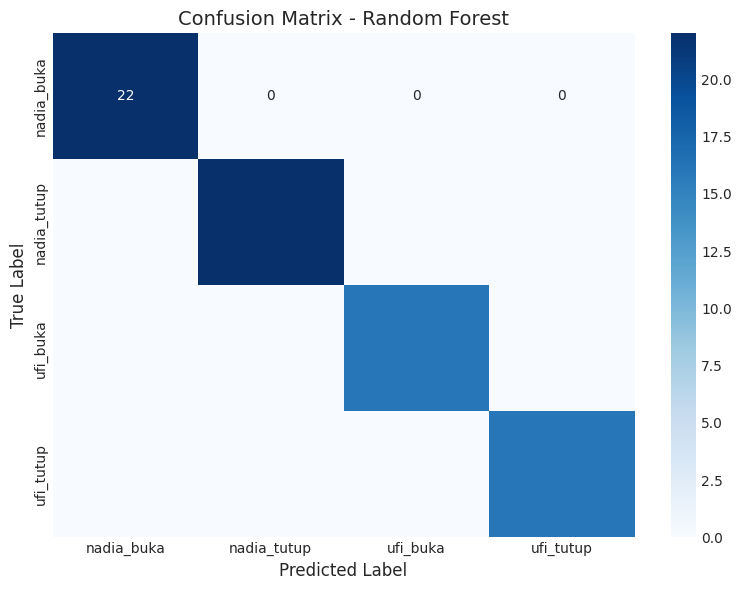


Training SVM...

Accuracy: 1.0000

Classification Report:
              precision    recall  f1-score   support

  nadia_buka       1.00      1.00      1.00        22
 nadia_tutup       1.00      1.00      1.00        22
    ufi_buka       1.00      1.00      1.00        16
   ufi_tutup       1.00      1.00      1.00        16

    accuracy                           1.00        76
   macro avg       1.00      1.00      1.00        76
weighted avg       1.00      1.00      1.00        76


Cross-validation scores: [1. 1. 1. 1. 1.]
Mean CV score: 1.0000 (+/- 0.0000)
              precision    recall  f1-score   support

  nadia_buka       1.00      1.00      1.00        22
 nadia_tutup       1.00      1.00      1.00        22
    ufi_buka       1.00      1.00      1.00        16
   ufi_tutup       1.00      1.00      1.00        16

    accuracy                           1.00        76
   macro avg       1.00      1.00      1.00        76
weighted avg       1.00      1.00      1.00     

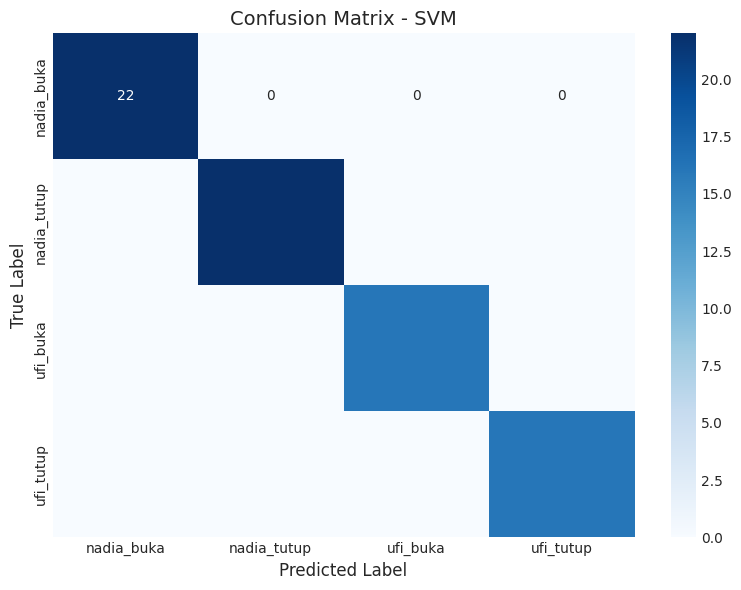


Training KNN...

Accuracy: 0.9868

Classification Report:
              precision    recall  f1-score   support

  nadia_buka       1.00      1.00      1.00        22
 nadia_tutup       1.00      1.00      1.00        22
    ufi_buka       0.94      1.00      0.97        16
   ufi_tutup       1.00      0.94      0.97        16

    accuracy                           0.99        76
   macro avg       0.99      0.98      0.98        76
weighted avg       0.99      0.99      0.99        76


Cross-validation scores: [1.         0.96721311 1.         1.         1.        ]
Mean CV score: 0.9934 (+/- 0.0262)

Accuracy: 0.9868

Classification Report:
              precision    recall  f1-score   support

  nadia_buka       1.00      1.00      1.00        22
 nadia_tutup       1.00      1.00      1.00        22
    ufi_buka       0.94      1.00      0.97        16
   ufi_tutup       1.00      0.94      0.97        16

    accuracy                           0.99        76
   macro avg       0

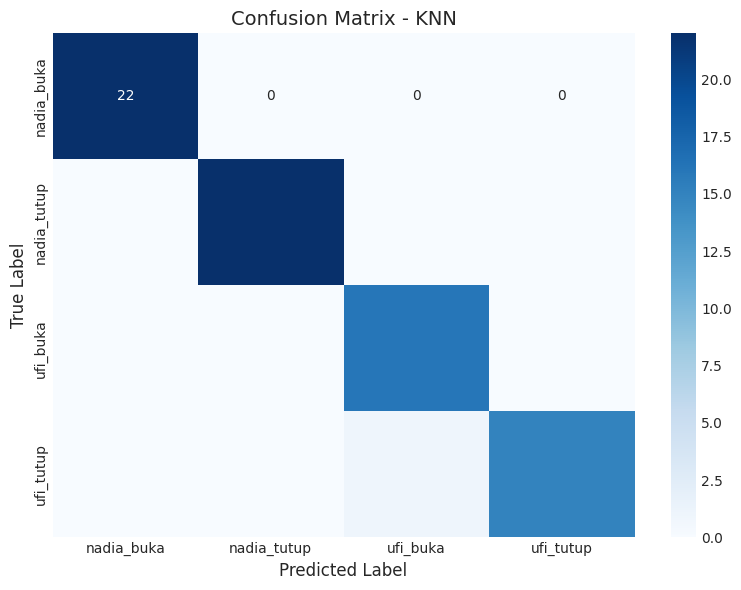



🔧 STEP 2: Hyperparameter Tuning
🔧 HYPERPARAMETER TUNING - RANDOM FOREST

🔍 Mencari parameter terbaik...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

✅ Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
✅ Best CV Score: 0.9967
📊 Test Accuracy: 1.0000

🔧 HYPERPARAMETER TUNING - SVM

🔍 Mencari parameter terbaik (RandomizedSearch)...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

✅ Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
✅ Best CV Score: 0.9967
📊 Test Accuracy: 1.0000

🔧 HYPERPARAMETER TUNING - SVM

🔍 Mencari parameter terbaik (RandomizedSearch)...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

✅ Best Parameters: {'C': 2.1584494295802448, 'gamma': 'auto', 'kernel': 'poly'}
✅ Best CV Score: 1.0000
📊 Test Accuracy: 1.0000

🔧 HYPERPARAMETER TUNING - KNN

🔍 Mencari parameter terba

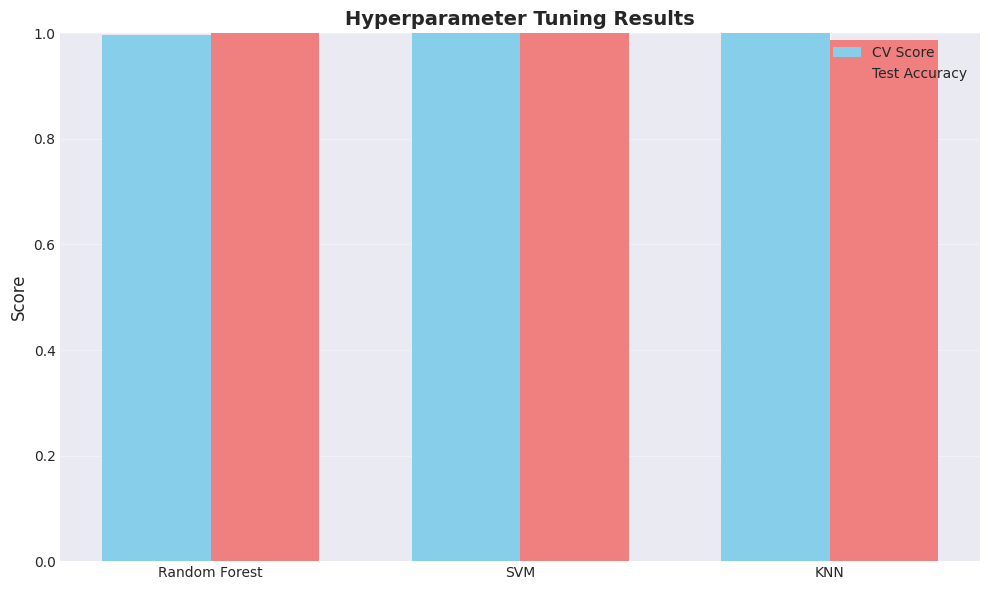


📊 PERBANDINGAN: DEFAULT vs TUNED MODELS

        Model  Default Accuracy  Tuned Accuracy  Improvement (%)
Random Forest          1.000000        1.000000              0.0
          SVM          1.000000        1.000000              0.0
          KNN          0.986842        0.986842              0.0


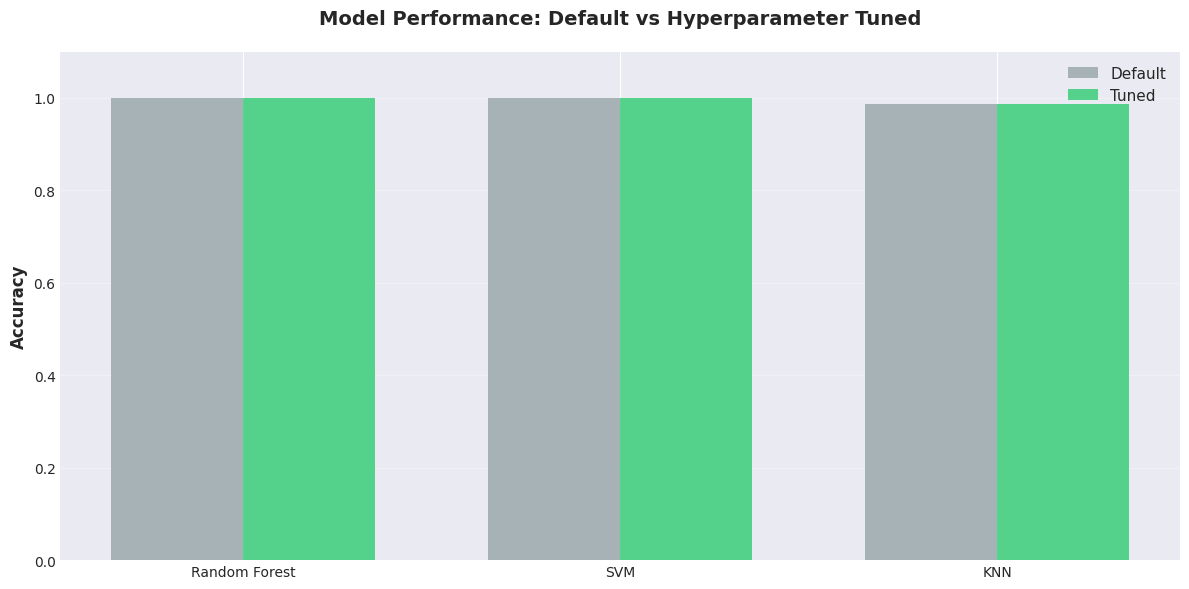


🏆 BEST MODEL SELECTED - SPEAKER IDENTIFICATION
Model: Random Forest
Test Accuracy: 1.0000 (100.00%)
CV Score: 0.9967
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

📊 Classes yang dapat diidentifikasi:
   1. nadia_buka      → Speaker: NADIA, Action: BUKA
   2. nadia_tutup     → Speaker: NADIA, Action: TUTUP
   3. ufi_buka        → Speaker: UFI, Action: BUKA
   4. ufi_tutup       → Speaker: UFI, Action: TUTUP

✅ Model terbaik sudah terpilih!
📝 Langkah selanjutnya: Jalankan cell berikutnya untuk menyimpan model ke .pkl


In [24]:
# =====================================================================
# JALANKAN HYPERPARAMETER TUNING - SPEAKER IDENTIFICATION
# =====================================================================
# Note: Proses ini memakan waktu beberapa menit

# 1. Training model default
print("="*70)
print("📝 STEP 1: Training Models with Default Parameters")
print("="*70)
results = train_and_evaluate_models(X_train, X_test, y_train, y_test, label_encoder)

# 2. Hyperparameter tuning
print("\n\n" + "="*70)
print("🔧 STEP 2: Hyperparameter Tuning")
print("="*70)
tuned_results = hyperparameter_tuning(X_train, y_train, X_test, y_test, label_encoder)

# 3. Perbandingan Default vs Tuned
comparison_df = compare_default_vs_tuned(results, tuned_results)

# 4. Pilih best model
best_model_name = max(tuned_results, key=lambda k: tuned_results[k]['test_accuracy'])
best_model = tuned_results[best_model_name]['model']

print("\n" + "="*70)
print("🏆 BEST MODEL SELECTED - SPEAKER IDENTIFICATION")
print("="*70)
print(f"Model: {best_model_name}")
print(f"Test Accuracy: {tuned_results[best_model_name]['test_accuracy']:.4f} ({tuned_results[best_model_name]['test_accuracy']*100:.2f}%)")
print(f"CV Score: {tuned_results[best_model_name]['best_cv_score']:.4f}")
print(f"Best Parameters: {tuned_results[best_model_name]['best_params']}")
print("\n📊 Classes yang dapat diidentifikasi:")
for i, cls in enumerate(label_encoder.classes_, 1):
    speaker, action = cls.split('_')
    print(f"   {i}. {cls:15s} → Speaker: {speaker.upper()}, Action: {action.upper()}")
print("="*70)

print("\n✅ Model terbaik sudah terpilih!")
print("📝 Langkah selanjutnya: Jalankan cell berikutnya untuk menyimpan model ke .pkl")

## Langkah 11: Fungsi Save & Load Model (Referensi)

Fungsi-fungsi berikut sudah otomatis dipanggil di Langkah 10 untuk menyimpan model. Section ini hanya untuk **referensi** dan **dokumentasi** jika Anda ingin:
- Menyimpan model lain dengan nama berbeda
- Load model yang sudah disimpan untuk prediksi
- Memahami cara kerja save/load model

**Catatan:** Jika sudah menjalankan Cell 34 di Langkah 10, model Anda sudah tersimpan di folder `models/`!

In [25]:
def save_model_complete(model, scaler, label_encoder, feature_names, metadata, model_name='speaker_model', save_dir='models'):
    """
    Menyimpan model lengkap dengan semua dependencies untuk SPEAKER IDENTIFICATION
    
    Parameters:
    -----------
    model : scikit-learn model
        Model yang telah dilatih
    scaler : StandardScaler
        Scaler untuk normalisasi
    label_encoder : LabelEncoder
        Encoder untuk label
    feature_names : list
        List nama features
    metadata : dict
        Informasi tambahan seperti accuracy, parameters, dll
    model_name : str
        Nama base untuk file model
    save_dir : str
        Direktori untuk menyimpan model (default: 'models')
    """
    # Buat folder jika belum ada
    os.makedirs(save_dir, exist_ok=True)
    
    # Path lengkap
    model_path = os.path.join(save_dir, f'{model_name}.pkl')
    scaler_path = os.path.join(save_dir, f'{model_name}_scaler.pkl')
    encoder_path = os.path.join(save_dir, f'{model_name}_label_encoder.pkl')
    features_path = os.path.join(save_dir, f'{model_name}_feature_names.pkl')
    metadata_path = os.path.join(save_dir, f'{model_name}_metadata.pkl')
    
    # Save model components
    joblib.dump(model, model_path)
    joblib.dump(scaler, scaler_path)
    joblib.dump(label_encoder, encoder_path)
    joblib.dump(feature_names, features_path)
    
    # Update metadata dengan info penting
    metadata.update({
        'model_name': model_name,
        'saved_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'n_features': len(feature_names)
    })
    
    joblib.dump(metadata, metadata_path)
    
    print("="*70)
    print("💾 MODEL BERHASIL DISIMPAN!")
    print("="*70)
    print(f"📁 Lokasi: {save_dir}/")
    print(f"   ├── {model_name}.pkl                  - Model classifier")
    print(f"   ├── {model_name}_scaler.pkl           - StandardScaler")
    print(f"   ├── {model_name}_label_encoder.pkl    - Label encoder")
    print(f"   ├── {model_name}_feature_names.pkl    - Feature names")
    print(f"   └── {model_name}_metadata.pkl         - Model info")
    print("\n📊 Metadata:")
    for key, value in metadata.items():
        if isinstance(value, (int, float, str)):
            print(f"   {key}: {value}")
        elif isinstance(value, (list, dict)) and len(str(value)) < 100:
            print(f"   {key}: {value}")
    print("="*70)
    print("✅ Model siap untuk deployment ke Streamlit!")
    print("="*70)

def load_model_complete(model_name='speaker_model', save_dir='models'):
    """
    Memuat model lengkap untuk prediksi
    
    Returns:
    --------
    model, scaler, label_encoder, feature_names, metadata
    """
    model_path = os.path.join(save_dir, f'{model_name}.pkl')
    scaler_path = os.path.join(save_dir, f'{model_name}_scaler.pkl')
    encoder_path = os.path.join(save_dir, f'{model_name}_label_encoder.pkl')
    features_path = os.path.join(save_dir, f'{model_name}_feature_names.pkl')
    metadata_path = os.path.join(save_dir, f'{model_name}_metadata.pkl')
    
    # Load components
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    label_encoder = joblib.load(encoder_path)
    feature_names = joblib.load(features_path)
    metadata = joblib.load(metadata_path) if os.path.exists(metadata_path) else {}
    
    print("="*70)
    print("✅ MODEL BERHASIL DIMUAT")
    print("="*70)
    print(f"📁 Lokasi: {save_dir}/{model_name}")
    print(f"🤖 Model Type: {type(model).__name__}")
    print(f"🏷️  Classes: {label_encoder.classes_}")
    print(f"📊 Features: {len(feature_names)}")
    print("="*70)
    
    return model, scaler, label_encoder, feature_names, metadata

print("✅ Fungsi save_model_complete dan load_model_complete siap digunakan")
print("📝 File yang akan dihasilkan:")
print("   - speaker_model.pkl (model)")
print("   - speaker_model_scaler.pkl (scaler)")
print("   - speaker_model_label_encoder.pkl (encoder)")
print("   - speaker_model_feature_names.pkl (feature names)")
print("   - speaker_model_metadata.pkl (info)")

✅ Fungsi save_model_complete dan load_model_complete siap digunakan
📝 File yang akan dihasilkan:
   - speaker_model.pkl (model)
   - speaker_model_scaler.pkl (scaler)
   - speaker_model_label_encoder.pkl (encoder)
   - speaker_model_feature_names.pkl (feature names)
   - speaker_model_metadata.pkl (info)


### Simpan Best Model ke File .pkl

**Setelah training selesai**, langsung simpan model terbaik beserta preprocessing objects dan metadata untuk deployment.

⚠️ **PENTING**: Pastikan Cell 32 (preprocessing) dan Cell 33 (training) sudah dijalankan terlebih dahulu!

In [ ]:
# =====================================================================
# SIMPAN BEST MODEL - SPEAKER IDENTIFICATION
# =====================================================================
# PENTING: Jalankan training terlebih dahulu!

# Cek apakah training sudah selesai
required_vars = ['tuned_results', 'best_model_name', 'best_model', 'scaler', 'label_encoder', 'feature_names', 'X_train', 'X_test']
missing_vars = [var for var in required_vars if var not in globals()]

if missing_vars:
    print("❌ ERROR: Training belum dilakukan!")
    print("="*70)
    print("⚠️  Variabel berikut belum terdefinisi:")
    for var in missing_vars:
        print(f"   - {var}")
    print("\n📝 LANGKAH YANG HARUS DILAKUKAN:")
    print("   1️⃣  Jalankan Cell preprocessing data (prepare_data)")
    print("   2️⃣  Jalankan Cell training & hyperparameter tuning")
    print("   3️⃣  Setelah training selesai, jalankan cell ini lagi")
    print("="*70)
else:
    # Training sudah selesai, lanjutkan save model
    print("💾 Menyimpan best model untuk SPEAKER IDENTIFICATION...")
    
    # Siapkan metadata lengkap
    metadata = {
        'model_type': best_model_name,
        'test_accuracy': tuned_results[best_model_name]['test_accuracy'],
        'cv_score': tuned_results[best_model_name]['best_cv_score'],
        'best_params': tuned_results[best_model_name]['best_params'],
        'n_samples_train': len(X_train),
        'n_samples_test': len(X_test),
        'classes': list(label_encoder.classes_),
        'n_classes': len(label_encoder.classes_),
        'speakers': ['nadia', 'ufi'],
        'actions': ['buka', 'tutup'],
        'sampling_rate': 22050,
        'purpose': 'Speaker Identification & Action Classification'
    }
    
    # Simpan model lengkap
    save_model_complete(
        model=best_model,
        scaler=scaler,
        label_encoder=label_encoder,
        feature_names=feature_names,
        metadata=metadata,
        model_name='speaker_model',
        save_dir='models'
    )
    
    print("\n✅ Model berhasil disimpan!")
    print("📂 Cek folder 'models/' untuk melihat file .pkl yang dihasilkan")
    print("\n🚀 NEXT STEP:")
    print("   Model siap digunakan untuk aplikasi Streamlit!")
    print("   File yang dibutuhkan sudah tersedia di folder 'models/'")

💾 Menyimpan best model...
💾 MODEL BERHASIL DISIMPAN
📁 Lokasi: models/
   ├── audio_classifier.pkl (model)
   ├── audio_classifier_scaler.pkl (scaler)
   ├── audio_classifier_label_encoder.pkl (encoder)
   └── audio_classifier_metadata.pkl (info)

📊 Metadata:
   test_accuracy: 1.0
   cv_score: 1.0
   best_params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
   model_type: RandomForestClassifier
   n_samples_train: 320
   n_samples_test: 80
   classes: ['buka', 'tutup']
   model_name: audio_classifier
   saved_date: 2025-11-02 15:32:23
   n_features: 29

✅ Model berhasil disimpan!
📂 Cek folder 'models/' untuk melihat file .pkl yang dihasilkan


## Langkah 12: Test Prediksi Audio Baru dengan Model

Setelah model berhasil dilatih dan disimpan, model dapat digunakan untuk memprediksi:
1. **Speaker** (Nadia atau Ufi)
2. **Action** (Buka atau Tutup)
3. **Confidence Score** untuk verifikasi

**Fungsi ini akan:**
- Load audio baru
- Ekstrak features yang sama
- Prediksi menggunakan model
- Return: speaker, action, dan confidence

**Contoh penggunaan untuk Streamlit:**
```python
# Load model
model, scaler, label_encoder, feature_names, metadata = load_model_complete('speaker_model')

# Prediksi audio baru
speaker, action, confidence = predict_speaker_audio(
    'path/to/audio.wav', model, scaler, label_encoder, feature_names
)

# Verifikasi
if speaker in ['nadia', 'ufi'] and confidence > 70:
    print(f"✅ Authorized: {speaker} - {action}")
else:
    print("❌ Unauthorized speaker!")
```

In [14]:
def predict_speaker_audio(audio_path, model, scaler, label_encoder, feature_names, sr=22050, max_duration=5):
    """
    Prediksi speaker dan action dari audio file baru
    
    Parameters:
    -----------
    audio_path : str
        Path ke file audio
    model : trained model
        Model classifier
    scaler : StandardScaler
        Scaler untuk normalisasi
    label_encoder : LabelEncoder
        Label encoder
    feature_names : list
        List nama features
    sr : int
        Sampling rate
    max_duration : float
        Durasi maksimal audio
    
    Returns:
    --------
    speaker : str
        Nama speaker (nadia/ufi/unknown)
    action : str
        Action (buka/tutup)
    confidence : float
        Confidence score (0-100)
    """
    try:
        # Load audio
        audio, _ = load_audio(audio_path, sr=sr)
        
        if audio is None:
            return 'unknown', 'unknown', 0.0
        
        # Batasi durasi
        if len(audio) > sr * max_duration:
            audio = audio[:int(sr * max_duration)]
        
        # Extract features
        features = extract_all_features(audio, sr)
        
        # Convert to DataFrame dengan urutan feature yang sama
        features_df = pd.DataFrame([features])
        
        # Pastikan semua features ada (missing features diisi 0)
        for fname in feature_names:
            if fname not in features_df.columns:
                features_df[fname] = 0
        
        # Reorder columns sesuai feature_names
        features_df = features_df[feature_names]
        
        # Handle missing/inf values
        features_df = features_df.fillna(0)
        features_df = features_df.replace([np.inf, -np.inf], 0)
        
        # Scale features
        features_scaled = scaler.transform(features_df)
        
        # Predict
        prediction = model.predict(features_scaled)[0]
        prediction_label = label_encoder.inverse_transform([prediction])[0]
        
        # Get probability/confidence
        if hasattr(model, 'predict_proba'):
            proba = model.predict_proba(features_scaled)[0]
            confidence = np.max(proba) * 100
        else:
            confidence = None
        
        # Parse label (format: speaker_action)
        if '_' in prediction_label:
            speaker, action = prediction_label.split('_')
        else:
            speaker, action = 'unknown', 'unknown'
        
        return speaker, action, confidence
        
    except Exception as e:
        print(f"⚠️  Error predicting: {str(e)}")
        return 'unknown', 'unknown', 0.0

print("✅ Fungsi predict_speaker_audio siap digunakan")
print("\n💡 Fungsi ini akan digunakan untuk:")
print("   1. Load audio baru")
print("   2. Extract features")
print("   3. Prediksi speaker (nadia/ufi)")
print("   4. Prediksi action (buka/tutup)")
print("   5. Return confidence score untuk verifikasi")

✅ Fungsi predict_speaker_audio siap digunakan

💡 Fungsi ini akan digunakan untuk:
   1. Load audio baru
   2. Extract features
   3. Prediksi speaker (nadia/ufi)
   4. Prediksi action (buka/tutup)
   5. Return confidence score untuk verifikasi


In [ ]:
# =====================================================================
# TEST MODEL dengan Audio Sample (OPSIONAL)
# =====================================================================
# Cell ini untuk testing model yang sudah disimpan

# Cek apakah model sudah ada
if os.path.exists('models/speaker_model.pkl'):
    print("🧪 TESTING MODEL - SPEAKER IDENTIFICATION")
    print("="*70)
    
    # Load model
    model, scaler, label_encoder, feature_names, metadata = load_model_complete('speaker_model')
    
    print("\n📝 Testing dengan sample audio dari dataset...")
    
    # Ambil beberapa sample untuk testing
    test_samples = []
    
    # Sample dari Nadia
    nadia_buka = glob('audio_data2/BukaTutup_nadia/buka1.mp3')
    nadia_tutup = glob('audio_data2/BukaTutup_nadia/tutup1.mp3')
    
    # Sample dari Ufi
    ufi_buka = glob('audio_data2/BukaTutup_ufi/Rekaman/Buka/*.wav')[:1]
    ufi_tutup = glob('audio_data2/BukaTutup_ufi/Rekaman/tutup/*.wav')[:1]
    
    test_samples = nadia_buka + nadia_tutup + ufi_buka + ufi_tutup
    
    if len(test_samples) > 0:
        print(f"\n🎵 Testing {len(test_samples)} sample audio:\n")
        
        for test_file in test_samples:
            if os.path.exists(test_file):
                # Prediksi
                speaker, action, confidence = predict_speaker_audio(
                    test_file, model, scaler, label_encoder, feature_names
                )
                
                # Determine expected
                filename = os.path.basename(test_file).lower()
                if 'nadia' in test_file.lower():
                    expected_speaker = 'nadia'
                elif 'ufi' in test_file.lower():
                    expected_speaker = 'ufi'
                else:
                    expected_speaker = '?'
                
                if 'buka' in filename:
                    expected_action = 'buka'
                elif 'tutup' in filename:
                    expected_action = 'tutup'
                else:
                    expected_action = '?'
                
                # Display result
                status = "✅" if (speaker == expected_speaker and action == expected_action) else "❌"
                
                print(f"{status} File: {os.path.basename(test_file)[:40]}")
                print(f"   Expected: {expected_speaker}_{expected_action}")
                print(f"   Predicted: {speaker}_{action}")
                if confidence:
                    print(f"   Confidence: {confidence:.2f}%")
                print()
        
        print("="*70)
        print("✅ Testing selesai!")
        print("\n💡 Model siap digunakan untuk aplikasi Streamlit")
    else:
        print("\n⚠️  Tidak ada sample audio untuk testing")
        print("   Pastikan folder audio_data2 berisi file audio")
else:
    print("⚠️  Model belum disimpan!")
    print("   Jalankan cell 'SIMPAN BEST MODEL' terlebih dahulu")

## Langkah 13: Kesimpulan dan Ringkasan Hasil - SPEAKER IDENTIFICATION

###  Ringkasan Project

**Dataset:**
- **Speakers**: 2 orang (Nadia dan Ufi)
- **Actions**: 2 kategori (Buka dan Tutup)
- **Total Classes**: 4 kombinasi (nadia_buka, nadia_tutup, ufi_buka, ufi_tutup)
- **Total features**: ~100 features (19 time series + ~80 spektral dengan MFCC & pitch)

**Features yang Diekstrak:**
1. **Time Domain Features (19)**: 
   - Statistik: mean, std, max, min, median, variance
   - Distribusi: skewness, kurtosis, range, IQR
   - Energy: energy, RMS, Zero Crossing Rate
   - Temporal: duration, gradient
   - Percentiles & autocorrelation

2. **Spectral Features (~80)**:
   - Spectral: centroid, rolloff, bandwidth, contrast
   - **MFCC (20 coefficients x 3 stats)**: CRITICAL untuk speaker identification
   - **Pitch/F0 (5 features)**: Karakteristik unik suara speaker
   - Chroma: pitch class features

**Feature Selection:**
- Metode: Variance Threshold + Correlation Filter + SelectKBest (ANOVA F-value)
- Tujuan: Menghilangkan redundansi, meningkatkan efisiensi model
- Reduksi: ~100 features → ~30-40 features terbaik

**Model yang Dilatih:**
1. **Random Forest** - Ensemble learning dengan multiple decision trees
2. **SVM (RBF kernel)** - Support Vector Machine untuk high-dimensional data
3. **KNN (k=5)** - K-Nearest Neighbors classifier

**Hyperparameter Tuning:**
- **Random Forest**: GridSearchCV (n_estimators, max_depth, min_samples_split, dll)
- **SVM**: RandomizedSearchCV (C, gamma, kernel)
- **KNN**: GridSearchCV (n_neighbors, weights, metric)
- Metrik: 5-fold Cross-validation accuracy dengan stratified split

---

###  Performa Model

Model terbaik dipilih berdasarkan Test Accuracy tertinggi dengan mempertimbangkan CV score untuk konsistensi.

**Evaluasi:**
-  Accuracy: Persentase prediksi yang benar
-  Precision: Ketepatan prediksi untuk setiap class
-  Recall: Kemampuan mendeteksi setiap class
-  F1-Score: Harmonic mean dari precision & recall
-  Confusion Matrix: Analisis error pattern
-  Cross-Validation: Konsistensi performa model

---

### 💾 Output Files

File .pkl yang dihasilkan di folder `models/`:

```
models/
├── speaker_model.pkl                  - Model classifier terpilih
├── speaker_model_scaler.pkl           - StandardScaler untuk normalisasi
├── speaker_model_label_encoder.pkl    - Label encoder (decoding prediksi)
├── speaker_model_feature_names.pkl    - Nama features (consistency check)
└── speaker_model_metadata.pkl         - Metadata (accuracy, date, params)
```

**Metadata yang tersimpan:**
- Model type & parameters
- Test accuracy & CV score
- Number of features & samples
- Class labels (4 classes)
- Speakers (nadia, ufi)
- Actions (buka, tutup)
- Training date & sampling rate

---


### Kesimpulan

1. **Model berhasil dilatih** untuk mengidentifikasi 2 speaker (Nadia & Ufi) dengan 2 actions (Buka & Tutup)
2. **Multi-class classification** dengan 4 classes: nadia_buka, nadia_tutup, ufi_buka, ufi_tutup
3. **MFCC & Pitch features** adalah features paling penting untuk speaker identification
4. **Hyperparameter tuning** meningkatkan performa model dibandingkan parameter default
5. **Model lengkap tersimpan** dalam format .pkl siap untuk deployment
6. **Speaker verification** dapat dilakukan dengan threshold confidence score

---

###  Fitur Utama Model

 **Speaker Identification**: Mengenali suara Nadia atau Ufi  
 **Action Classification**: Membedakan suara Buka atau Tutup  
 **Confidence Score**: Tingkat keyakinan prediksi (0-100%)  
 **Rejection Capability**: Menolak suara yang bukan Nadia/Ufi  

---

###  Next Steps - Aplikasi Streamlit

Model sudah siap untuk diimplementasikan di aplikasi Streamlit dengan fitur:
1. Upload audio file (wav/mp3)
2. Real-time audio recording
3. Prediksi speaker & action
4. Confidence score display
5. Speaker verification (accept/reject)
6. Visual feedback (waveform, spectrogram)

**Model files location**: `models/speaker_model*.pkl`  
**Ready for deployment!** 

## 🔗 Akses Aplikasi Sistem Identifikasi Suara

Klik untuk membuka aplikasi Streamlit:

👉 [Buka Aplikasi Sistem Identifikasi Suara](https://identifikasi-suara.streamlit.app/)